In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import re
import os
import shutil
import math
import seaborn as sns
import nltk.translate.bleu_score as bleu
import matplotlib.ticker as ticker

import tensorflow as tf
from tensorflow.keras.layers import Embedding, LSTM, Dense, Activation, Dot
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

In [2]:
tf.keras.backend.clear_session()

In [3]:
data = pd.read_csv('preprocessed_data.csv')
data.head()

,italian,english_inp,english_out
0,ciao,<start> hi,hi <end>
1,corri,<start> run,run <end>
2,corra,<start> run,run <end>
3,correte,<start> run,run <end>
4,chi,<start> who,who <end>


In [4]:
train, validation = train_test_split(data, test_size=0.2, random_state=42)

print(train.shape, validation.shape)

(272932, 3) (68234, 3)


In [5]:
train.iloc[0,1] = str(train.iloc[0,1]) + ' <end>'

In [6]:
train.head(2)

,italian,english_inp,english_out
76648,lei ha acceso le candele,<start> she lit the candles <end>,she lit the candles <end>
246895,ecco una foto di tom che balla,<start> here is a picture of tom dancing,here is a picture of tom dancing <end>


In [7]:
validation.head(2)

,italian,english_inp,english_out
339758,tom e mary non vanno daccordo perché non hanno...,<start> tom and mary do not get along because ...,tom and mary do not get along because they hav...
113618,studi ogni giorno,<start> do you study every day,do you study every day <end>


In [8]:
tknizer_ita = Tokenizer(filters='')
tknizer_ita.fit_on_texts(train['italian'].values)

vocab_size_ita=len(tknizer_ita.word_index.keys())
print('Input Vocab Size:', vocab_size_ita)

Input Vocab Size: 26081


In [9]:
tknizer_eng = Tokenizer(filters='')
tknizer_eng.fit_on_texts(train['english_inp'].values)

vocab_size_eng=len(tknizer_eng.word_index.keys())
print('Output Vocab Size:', vocab_size_eng)

Output Vocab Size: 12771


In [10]:
tknizer_eng.word_index['<start>'], tknizer_eng.word_index['<end>']

(1, 10074)

In [11]:
end_word_index = tknizer_eng.word_index['<end>']
print(end_word_index)

10074


In [12]:
eng_index_word={}
eng_word_index={}
for key,value in tknizer_eng.word_index.items():
    eng_index_word[value] = key 
    eng_word_index[key] = value

In [13]:
# Parameters
max_length = 20
batch_size = 1024

In [14]:
# Reference : Assignment
class Dataset:
    def __init__(self, data, tknizer_ita, tknizer_eng, max_len):
        self.encoder_inps = data['italian'].values
        self.decoder_inps = data['english_inp'].values
        self.decoder_outs = data['english_out'].values
        self.tknizer_eng = tknizer_eng
        self.tknizer_ita = tknizer_ita
        self.max_len = max_len

    def __getitem__(self, i):
        self.encoder_seq = self.tknizer_ita.texts_to_sequences([self.encoder_inps[i]])
        self.decoder_inp_seq = self.tknizer_eng.texts_to_sequences([self.decoder_inps[i]])
        self.decoder_out_seq = self.tknizer_eng.texts_to_sequences([self.decoder_outs[i]])

        self.encoder_seq = pad_sequences(self.encoder_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_inp_seq = pad_sequences(self.decoder_inp_seq, maxlen=self.max_len, dtype='int32', padding='post')
        self.decoder_out_seq = pad_sequences(self.decoder_out_seq, maxlen=self.max_len, dtype='int32', padding='post')
        return self.encoder_seq, self.decoder_inp_seq, self.decoder_out_seq

    def __len__(self):
        return len(self.encoder_inps)

In [15]:
train_dataset = Dataset(train, tknizer_ita, tknizer_eng, max_length)
test_dataset  = Dataset(validation, tknizer_ita, tknizer_eng, max_length)

In [16]:
print(train_dataset[0])
print('\n')
train.head(1)

(array([[  19,   10, 2403,   23, 2172,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]]), array([[    1,    37,  2018,     8,  1826, 10074,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]]), array([[   37,  2018,     8,  1826, 10074,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0]]))




,italian,english_inp,english_out
76648,lei ha acceso le candele,<start> she lit the candles <end>,she lit the candles <end>


In [17]:
# Reference : Assignment
class Dataloader(tf.keras.utils.Sequence):    
    def __init__(self, dataset, batch_size=1, is_matrix=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.indexes = 0
        if(is_matrix == False):
            self.indexes = np.arange(len(self.dataset.encoder_inps))
            
    def __getitem__(self, i):
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        batch = [np.squeeze(np.stack(samples, axis=1), axis=0) for samples in zip(*data)]
        return tuple([[batch[0], batch[1]], batch[2]])

    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.random.permutation(self.indexes)

In [18]:
train_dataloader = Dataloader(train_dataset, batch_size=batch_size, is_matrix=False)
test_dataloader = Dataloader(test_dataset, batch_size=batch_size, is_matrix=False)

print(train_dataloader[0][0][0].shape, test_dataloader[0][0][0].shape)

(1024, 20) (1024, 20)


<font color='blue'>**Encoder**</font>

In [19]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, vocab_size, embedding_dim, enc_units, input_length):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.input_length = input_length
        self.enc_units= enc_units
        self.lstm_output = 0
        self.lstm_state_h=0
        self.lstm_state_c=0
        
    def build(self, input_shape):
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, input_length=self.input_length,
                           mask_zero=True, name="embedding_layer_encoder")
        self.lstm = LSTM(self.enc_units, return_state=True, return_sequences=True, name="Encoder_LSTM")
        
    def call(self, input_sentances, training=True):
        input_embedd = self.embedding(input_sentances)
        self.lstm_output, self.lstm_state_h,self.lstm_state_c = self.lstm(input_embedd)
        return self.lstm_output, self.lstm_state_h,self.lstm_state_c
    
    def initialize_states(self, batch_size):
        self.lstm_state_h = tf.zeros((batch_size, self.enc_units))
        self.lstm_state_c = tf.zeros((batch_size, self.enc_units))
        return self.lstm_state_h, self.lstm_state_c

<font color='cyan'>**Grader function - 1**</font>

In [20]:
def grader_check_encoder():
    vocab_size=10
    embedding_size=20
    lstm_size=32
    input_length=10
    batch_size=16
    encoder=Encoder(vocab_size,embedding_size,lstm_size,input_length)
    input_sequence=tf.random.uniform(shape=[batch_size,input_length],maxval=vocab_size,minval=0,dtype=tf.int32)
    initial_state=encoder.initialize_states(batch_size)
    encoder_output,state_h,state_c=encoder(input_sequence,initial_state)
    
    assert(encoder_output.shape==(batch_size,input_length,lstm_size) and state_h.shape==(batch_size,lstm_size) and state_c.shape==(batch_size,lstm_size))
    return True
print(grader_check_encoder())

True


<font color='blue'>**Attention**</font>

In [21]:
class Attention(tf.keras.layers.Layer):
    def __init__(self, scoring_function, att_units, print_size=True):
        super().__init__()
        self.scoring_function = scoring_function
        self.att_units = att_units
        self.print_size = print_size
        self.attn_weights = 0
        self.context_vector = 0
        
        if self.scoring_function == 'general':
#             self.w = self.add_weight(shape=(input_length, 1), initializer='he_normal', trainable=True)
            self.w = tf.keras.layers.Dense(1, activation='relu', kernel_initializer='he_normal')
        elif self.scoring_function == 'concat':
            self.w1 = tf.keras.layers.Dense(self.att_units, activation='relu', kernel_initializer='he_normal')
            self.w2 = tf.keras.layers.Dense(self.att_units, activation='relu', kernel_initializer='he_normal')
            self.v = tf.keras.layers.Dense(1, activation='relu', kernel_initializer='he_normal')

    def call(self, decoder_h_state, encoder_output):
        if self.scoring_function == 'dot':
            hidden_state = tf.expand_dims(decoder_h_state, axis=1)
            score = Dot(axes=(2))([encoder_output, hidden_state])
            self.attn_weights = tf.nn.softmax(score, axis=1)
            self.context_vector = self.attn_weights * encoder_output
            self.context_vector = tf.reduce_sum(self.context_vector, axis=1)
            if(self.print_size == True):
                print('\n')
                print('='*50)
                print('Dot Model')
                print('='*50)
                print('Encoder Shape:', encoder_output.shape)
                print('Decoder Hidden Shape:', hidden_state.shape)
                print('Score (Dot Product) Shape:', score.shape)
                print('Attention Shape (Score + softmax):', self.attn_weights.shape)
                print('Context Vector Shape:', self.context_vector.shape)
                print('\n')
            
        elif self.scoring_function == 'general':
            hidden_state = tf.expand_dims(decoder_h_state, axis=1)
            score = Dot(axes=(2))([encoder_output, hidden_state])
            score = self.w(score)
            self.attn_weights = tf.nn.softmax(score, axis=1)
            self.context_vector = self.attn_weights * encoder_output
            self.context_vector = tf.reduce_sum(self.context_vector, axis=1)
            if(self.print_size == True):
                print('\n')
                print('='*50)
                print('General Model')
                print('='*50)
                print('Encoder Shape:', encoder_output.shape)
                print('Decoder Hidden Shape:', hidden_state.shape)
                print('Score (Dot Product) Shape:', score.shape)
                print('Attention Shape (Score + softmax):', self.attn_weights.shape)
                print('Context Vector Shape:', self.context_vector.shape)
                print('\n')
            
        elif self.scoring_function == 'concat':
            hidden_state = tf.expand_dims(decoder_h_state, axis=1)
            score = self.v(tf.nn.tanh((self.w1(encoder_output)) + (self.w2(hidden_state))))
            self.attn_weights = tf.nn.softmax(score, axis=1)
            self.context_vector = self.attn_weights * encoder_output
            self.context_vector = tf.reduce_sum(self.context_vector, axis=1)
            if(self.print_size == True):
                print('\n')
                print('='*50)
                print('Concat Model')
                print('='*50)
                print('Encoder Shape:', encoder_output.shape)
                print('Decoder Hidden Shape:', hidden_state.shape)
                print('Score (Dot Product) Shape:', score.shape)
                print('Attention Shape (Score + softmax):', self.attn_weights.shape)
                print('Context Vector Shape:', self.context_vector.shape)
                print('\n')
            
        return self.context_vector, self.attn_weights

<font color='orange'>**Grader function - 2**</font>

In [22]:
def grader_check_attention(scoring_fun):
    
    ''' 
        att_units: Used in matrix multiplications for scoring functions,
        input_length: Length of the input sentence,
        batch_size
    '''
    
    input_length=10
    batch_size=16
    att_units=32
    
    state_h=tf.random.uniform(shape=[batch_size,att_units])
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,att_units])
    attention=Attention(scoring_fun,att_units)
    context_vector,attention_weights=attention(state_h,encoder_output)
    assert(context_vector.shape==(batch_size,att_units) and attention_weights.shape==(batch_size,input_length,1))
    return True
print(grader_check_attention('dot'))
print(grader_check_attention('general'))
print(grader_check_attention('concat'))



Dot Model
Encoder Shape: (16, 10, 32)
Decoder Hidden Shape: (16, 1, 32)
Score (Dot Product) Shape: (16, 10, 1)
Attention Shape (Score + softmax): (16, 10, 1)
Context Vector Shape: (16, 32)


True


General Model
Encoder Shape: (16, 10, 32)
Decoder Hidden Shape: (16, 1, 32)
Score (Dot Product) Shape: (16, 10, 1)
Attention Shape (Score + softmax): (16, 10, 1)
Context Vector Shape: (16, 32)


True


Concat Model
Encoder Shape: (16, 10, 32)
Decoder Hidden Shape: (16, 1, 32)
Score (Dot Product) Shape: (16, 10, 1)
Attention Shape (Score + softmax): (16, 10, 1)
Context Vector Shape: (16, 32)


True


<font color='blue'>**OneStepDecoder**</font>

In [23]:
class One_Step_Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, input_length, 
                 dec_units , score_fun, att_units, print_size=True):
        super().__init__()
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.dec_units = dec_units
        self.input_length = input_length
        self.att_units = att_units
        self.print_size = print_size
        
        self.embedding = Embedding(input_dim=self.vocab_size, output_dim=self.embedding_dim, 
                                   input_length=self.input_length, mask_zero=True, weights = None,
                                   name="embedding_layer_decoder", trainable=True)
        self.lstm = LSTM(self.dec_units, return_sequences=True, 
                         return_state=True, name="Decoder_LSTM")
        self.dense = Dense((vocab_size))
        self.attention = Attention(score_fun, att_units, print_size=self.print_size)
        
    def call(self, input_to_decoder, encoder_output, state_h, state_c):
        target_embedd = self.embedding(input_to_decoder)
        context_vector, attention_weights = self.attention(state_h, encoder_output)
        concat_data = tf.concat([tf.expand_dims(context_vector, 1), target_embedd], -1)
        lstm_output, state_h, state_c = self.lstm(concat_data, initial_state=[state_h, state_c])
        output = self.dense(lstm_output)
        output = tf.squeeze(output, 1)
        if(self.print_size == True):
            print('Embedding Shape:', target_embedd.shape)
            print('Concated Shape:', concat_data.shape)
            print('lstm_output Shape:', lstm_output.shape)
            print('Output Shape:', output.shape)
            print('state_h Shape:', state_h.shape)
            print('state_c Shape:', state_c.shape)
            print('attention_weights Shape:', attention_weights.shape)
            print('context_vector Shape:', context_vector.shape)
            print('\n')
            
        return output, state_h, state_c, attention_weights, context_vector

<font color='cyan'>**Grader function - 3**</font>

In [24]:
def grader_onestepdecoder(score_fun):
    
    '''
        tar_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    tar_vocab_size=13 
    embedding_dim=12 
    input_length=10
    dec_units=16 
    att_units=16
    batch_size=32
    onestepdecoder=One_Step_Decoder(tar_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    input_to_decoder=tf.random.uniform(shape=(batch_size,1),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    output,state_h,state_c,attention_weights,context_vector=onestepdecoder(input_to_decoder,encoder_output,state_h,state_c)
    assert(output.shape==(batch_size,tar_vocab_size))
    assert(state_h.shape==(batch_size,dec_units))
    assert(state_c.shape==(batch_size,dec_units))
    assert(attention_weights.shape==(batch_size,input_length,1))
    assert(context_vector.shape==(batch_size,dec_units))
    return True
    
print(grader_onestepdecoder('dot'))
print(grader_onestepdecoder('general'))
print(grader_onestepdecoder('concat'))



Dot Model
Encoder Shape: (32, 10, 16)
Decoder Hidden Shape: (32, 1, 16)
Score (Dot Product) Shape: (32, 10, 1)
Attention Shape (Score + softmax): (32, 10, 1)
Context Vector Shape: (32, 16)


Embedding Shape: (32, 1, 12)
Concated Shape: (32, 1, 28)
lstm_output Shape: (32, 1, 16)
Output Shape: (32, 13)
state_h Shape: (32, 16)
state_c Shape: (32, 16)
attention_weights Shape: (32, 10, 1)
context_vector Shape: (32, 16)


True


General Model
Encoder Shape: (32, 10, 16)
Decoder Hidden Shape: (32, 1, 16)
Score (Dot Product) Shape: (32, 10, 1)
Attention Shape (Score + softmax): (32, 10, 1)
Context Vector Shape: (32, 16)


Embedding Shape: (32, 1, 12)
Concated Shape: (32, 1, 28)
lstm_output Shape: (32, 1, 16)
Output Shape: (32, 13)
state_h Shape: (32, 16)
state_c Shape: (32, 16)
attention_weights Shape: (32, 10, 1)
context_vector Shape: (32, 16)


True


Concat Model
Encoder Shape: (32, 10, 16)
Decoder Hidden Shape: (32, 1, 16)
Score (Dot Product) Shape: (32, 10, 1)
Attention Shape (Score + s

<font color='blue'>**Decoder**</font>

In [25]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, out_vocab_size, embedding_dim, input_length, dec_units, score_fun, att_units):
        super().__init__()
        self.onestepdecoder = One_Step_Decoder(out_vocab_size, embedding_dim, input_length, dec_units, 
                                               score_fun, att_units, print_size=False)
    
    @tf.function
    def call(self, input_to_decoder, encoder_output, state_h, state_c):
        if (input_to_decoder.shape[1] is None):
            size = max_length
        else:
            size = input_to_decoder.shape[1]
        all_output = tf.TensorArray(tf.float32, size=size, name='output')
        for timestep in range(size):
            output, state_h, state_c, attention_weights, context_vector = self.onestepdecoder(input_to_decoder[:, timestep:timestep+1], 
                                                                                              encoder_output, state_h, state_c)
            all_output = all_output.write(timestep, output)
        all_output = tf.transpose(all_output.stack(), [1, 0, 2])
        return all_output

<font color='cyan'>**Grader function - 4**</font>

In [26]:
def grader_decoder(score_fun):
    
    '''
        out_vocab_size: Unique words of the target language,
        embedding_dim: output embedding dimension for each word after embedding layer,
        dec_units: Number of lstm units in decoder,
        att_units: Used in matrix multiplications for scoring functions in attention class,
        input_length: Length of the target sentence,
        batch_size
        
    
    '''
    
    out_vocab_size=13 
    embedding_dim=12 
    input_length=11
    dec_units=16 
    att_units=16
    batch_size=32
    
    target_sentences=tf.random.uniform(shape=(batch_size,input_length),maxval=10,minval=0,dtype=tf.int32)
    encoder_output=tf.random.uniform(shape=[batch_size,input_length,dec_units])
    state_h=tf.random.uniform(shape=[batch_size,dec_units])
    state_c=tf.random.uniform(shape=[batch_size,dec_units])
    
    decoder=Decoder(out_vocab_size, embedding_dim, input_length, dec_units ,score_fun ,att_units)
    output=decoder(target_sentences,encoder_output, state_h, state_c)
    assert(output.shape==(batch_size,input_length,out_vocab_size))
    return True
print(grader_decoder('dot'))
print(grader_decoder('general'))
print(grader_decoder('concat'))

True
True
True


<font color='blue'>**Encoder Decoder model**</font>

In [27]:
class Attention_Encoder_Decoder(tf.keras.Model):
    def __init__(self, encoder_inputs_length, decoder_inputs_length, vocab_size_ita, vocab_size_eng, model):
        super().__init__()
        self.encoder = Encoder(vocab_size_ita+1, 50, 256, encoder_inputs_length)
        self.decoder = Decoder(vocab_size_eng+1, 50, decoder_inputs_length, 256, model, 16)

    def call(self, data):
        input_data, output = data[0], data[1]
        initial_state = self.encoder.initialize_states(batch_size)
        encoder_output, state_h, state_c = self.encoder(input_data, initial_state)
        decoder_output = self.decoder(output, encoder_output, state_h, state_c)
        return decoder_output

<font color='blue'>**Custom loss function**</font>

In [28]:
# Reference: https://www.tensorflow.org/tutorials/text/nmt_with_attention#define_the_optimizer_and_the_loss_function
optimizer = tf.keras.optimizers.Adam()
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_mean(loss_)

In [29]:
# Reference: Assignment
if(os.path.exists('logs')):
    shutil.rmtree('logs')
    print('Old Log folder is deleted')

%reload_ext tensorboard

log_dir="logs"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                                      histogram_freq=0, 
                                                      write_graph=True)
print('New Log folder is created')

Old Log folder is deleted
New Log folder is created


In [30]:
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.9
    epochs_drop = 15
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    print('Learning Rate ->', lrate)
    return lrate

lr_reducer = tf.keras.callbacks.LearningRateScheduler(step_decay)

<font color='blue'>*** Dot Model - Training**</font>

In [31]:
model  = Attention_Encoder_Decoder(20, 20, vocab_size_ita, vocab_size_eng, 'general')
model.compile(optimizer=optimizer, loss=loss_function)
model.fit(train_dataloader, epochs=50,callbacks=[lr_reducer, tensorboard_callback])

Learning Rate -> 0.001
Epoch 1/50
266/266 [==============================] - 58s 216ms/step - loss: 1.8465 - lr: 0.0010
Learning Rate -> 0.001
Epoch 2/50
266/266 [==============================] - 57s 216ms/step - loss: 1.6104 - lr: 0.0010
Learning Rate -> 0.001
Epoch 3/50
266/266 [==============================] - 57s 216ms/step - loss: 1.5207 - lr: 0.0010
Learning Rate -> 0.001
Epoch 4/50
266/266 [==============================] - 58s 216ms/step - loss: 1.4043 - lr: 0.0010
Learning Rate -> 0.001
Epoch 5/50
266/266 [==============================] - 58s 216ms/step - loss: 1.2408 - lr: 0.0010
Learning Rate -> 0.001
Epoch 6/50
266/266 [==============================] - 58s 216ms/step - loss: 1.0935 - lr: 0.0010
Learning Rate -> 0.001
Epoch 7/50
266/266 [==============================] - 58s 216ms/step - loss: 0.9732 - lr: 0.0010
Learning Rate -> 0.001
Epoch 8/50
266/266 [==============================] - 58s 216ms/step - loss: 0.8736 - lr: 0.0010
Learning Rate -> 0.001
Epoch 9/50
266/26

In [32]:
model.summary()

Model: "attention__encoder__decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_1 (Encoder)          multiple                  1618468   
_________________________________________________________________
decoder_3 (Decoder)          multiple                  4497518   
Total params: 6,115,986
Trainable params: 6,115,986
Non-trainable params: 0
_________________________________________________________________


In [33]:
# %tensorboard --logdir logs

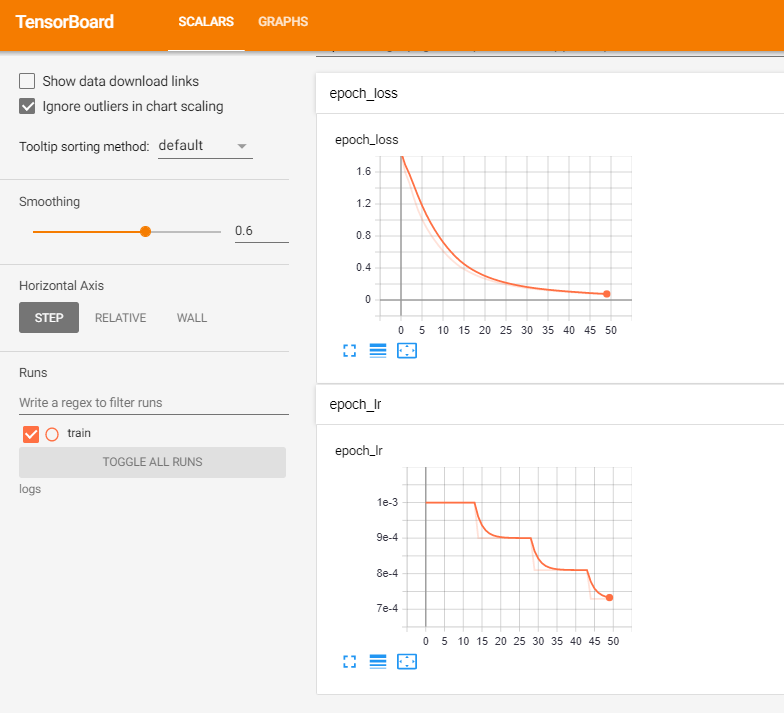

In [34]:
from IPython.display import Image
Image(filename='F:\\Applied AI\\Assignments\\25.NLP Attention Mechanism\\Tensorboard Results\\Task_2_General_Model.PNG')

In [35]:
model.save_weights("dot_model.hp5", save_format="tf")

In [36]:
def get_encoder_data(input_sentence, tknizer_ita):
    
    input_seq = tknizer_ita.texts_to_sequences([input_sentence])
    print('Tokenized sentence:', input_seq[0])
    
    input_seq = np.array(input_seq)

    initial_state = model.layers[0].initialize_states(batch_size)
    state_h = initial_state[0]
    state_c = initial_state[1]

    enc_output, enc_state_h, enc_state_c = model.layers[0](input_seq)
    
    states_values = [enc_state_h, enc_state_c]
    
    return enc_output, enc_state_h, enc_state_c

In [37]:
# Refrence: https://medium.com/analytics-vidhya/understand-sequence-to-sequence-models-in-a-more-intuitive-way-1d517d8795bb
def predict(input_sentence, tknizer_ita, plot=False, _print=True):
    encoder_output, state_h, state_c = get_encoder_data(input_sentence, tknizer_ita)
    
    stop_condition=False
    k=0
    translated_sentence = ''
    
    target_word = np.zeros((1,1), dtype='float32')
    target_word[0,0] = 1
    
    attention_matrix = []
    
    while not stop_condition:
        output, state_h, state_c, attention_weights, context_vector = model.layers[1].onestepdecoder(target_word, encoder_output, state_h, state_c)
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_matrix.append(attention_weights.numpy())
        target_word = np.reshape(np.argmax(output), (1, 1))
        if(_print):
            print('Predicted Index ->', np.argmax(output))
            print(target_word[0][0])
        predicted_word = eng_index_word.get(int(target_word[0][0]), '')
        k+=1
        if ((k > len(input_sentence.split())) or target_word[0][0] == end_word_index):
            stop_condition = True
        translated_sentence = translated_sentence + ' ' + predicted_word
        
    if (plot):
        fig = plt.figure(figsize=(5, 5))
        ax = fig.add_subplot(1, 1, 1)
        ax.matshow(attention_matrix, cmap='viridis')
        fontdict = {'fontsize': 14}
        ax.set_xticklabels(input_sentence.split(), fontdict=fontdict, rotation=90)
        ax.set_yticklabels(translated_sentence.split(), fontdict=fontdict)
        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
        plt.show()

    return translated_sentence

Tokenized sentence: [1, 2, 10, 11, 1702]
Predicted Index -> 4
4
Predicted Index -> 51
51
Predicted Index -> 7
7
Predicted Index -> 12
12
Predicted Index -> 68
68
Predicted Index -> 1557
1557


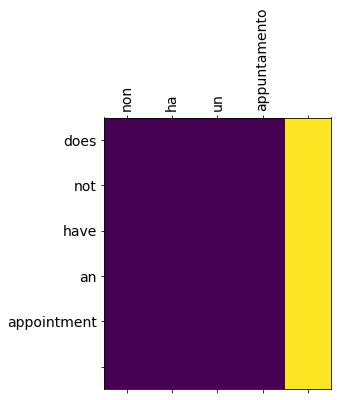

Translated Sentence:  tom does not have an appointment


In [38]:
input_sentence = "tom non ha un appuntamento"

output_sentence = predict(input_sentence, tknizer_ita, True, True)

print('Translated Sentence:', output_sentence)

In [39]:
# Blue Measurement
reference = [i.replace('<start> ', '').split() for i in list(validation['english_inp'])]
reference = reference[:1000]
print(len(reference))

1000


Given Sentence: io volevo nuotare ogni giorno
Tokenized sentence: [7, 264, 312, 144, 134]


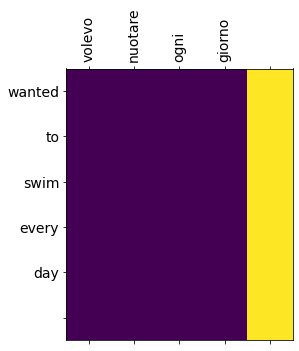

Translated Sentence:  i wanted to swim every day
Reference: ['i', 'wanted', 'to', 'swim', 'every', 'day']
BLEU score: 1.0


Given Sentence: questo tappeto è più prezioso di quello
Tokenized sentence: [24, 2677, 3, 33, 4468, 4, 70]


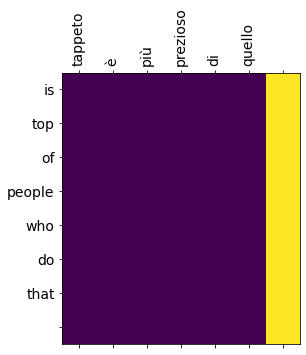

Translated Sentence:  this is top of people who do that
Reference: ['this', 'carpet', 'is', 'more', 'valuable', 'than', 'that', 'one']
BLEU score: 1.4256605770826504e-231


Given Sentence: che dolore
Tokenized sentence: [6, 1037]


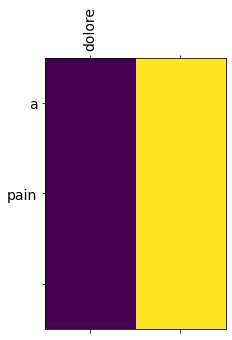

Translated Sentence:  what a pain
Reference: ['what', 'a', 'pain']
BLEU score: 1.2213386697554703e-77


Given Sentence: lui non ha per nulla paura dei serpenti
Tokenized sentence: [29, 2, 10, 13, 120, 208, 87, 2811]


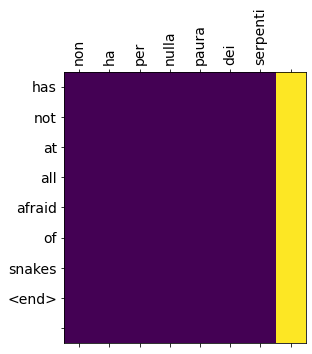

Translated Sentence:  he has not at all afraid of snakes <end>
Reference: ['he', 'is', 'not', 'at', 'all', 'afraid', 'of', 'snakes']
BLEU score: 0.6104735835807844


Given Sentence: non ho sentito aprire la porta
Tokenized sentence: [2, 16, 226, 1026, 8, 268]


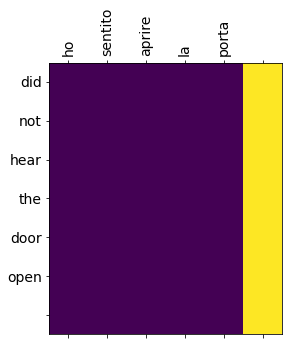

Translated Sentence:  i did not hear the door open
Reference: ['i', 'did', 'not', 'hear', 'the', 'door', 'open']
BLEU score: 1.0


Given Sentence: tom vuole del denaro
Tokenized sentence: [1, 84, 55, 222]


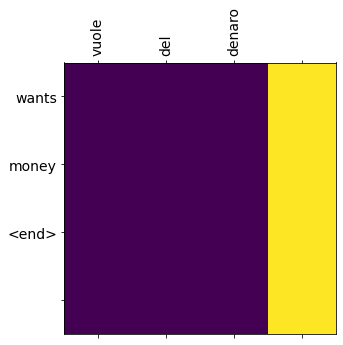

Translated Sentence:  tom wants money <end>
Reference: ['tom', 'wants', 'money']
BLEU score: 8.636168555094496e-78


Given Sentence: io non ti mentirei mai
Tokenized sentence: [7, 2, 68, 4834, 45]


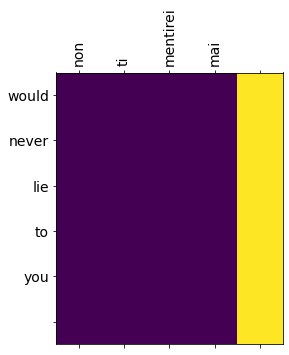

Translated Sentence:  i would never lie to you
Reference: ['i', 'would', 'never', 'lie', 'to', 'you']
BLEU score: 1.0


Given Sentence: ci mostri la stanza
Tokenized sentence: [46, 2597, 8, 215]


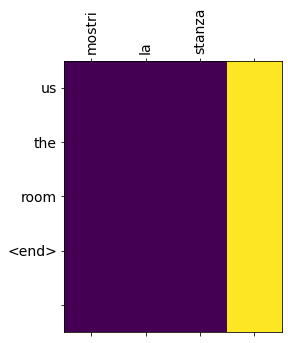

Translated Sentence:  show us the room <end>
Reference: ['show', 'us', 'the', 'room']
BLEU score: 0.668740304976422


Given Sentence: sembra semplice lo so
Tokenized sentence: [91, 1032, 25, 82]


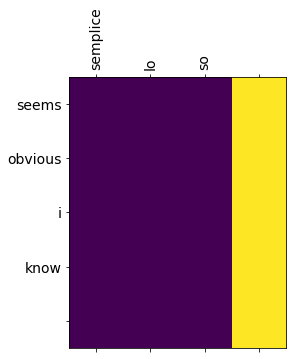

Translated Sentence:  it seems obvious i know
Reference: ['it', 'sounds', 'simple', 'i', 'know']
BLEU score: 9.283142785759642e-155


Given Sentence: entrambi sono vivi
Tokenized sentence: [448, 12, 1844]


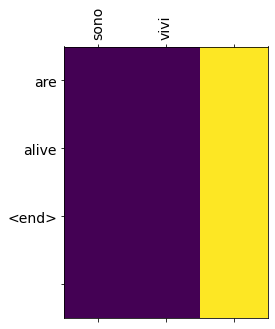

Translated Sentence:  both are alive <end>
Reference: ['both', 'are', 'alive']
BLEU score: 8.636168555094496e-78


Average Blue score:  0.4279213888557207


In [40]:
blue_score = 0
length = 10
for i in np.random.choice(list(validation.index), length):
    input_sentence = validation.loc[i, 'italian']
    print('Given Sentence:', input_sentence)
    translation = predict(input_sentence, tknizer_ita, True, False)
    print('Translated Sentence:', translation)
    reference = validation.loc[i, 'english_inp'].replace('<start> ', '').split()
    print('Reference:', reference)
    score = bleu.sentence_bleu([reference], translation.split())
    print('BLEU score: {}'.format(score))
    blue_score = blue_score + score
    print('\n')
print('Average Blue score: ', (blue_score/length))